# Climate Modeling Analysis of India using CMIP6

### Introduction: Climate In India and Its Significance 

India is a subcontinent in South Asia. It has a diverse array of biomes and climates, with the arid Thar Desert in the northwest, Himalayan mountain tundra in the northeast, the Indo-Gangetic Plain spanning across the north, the Peninsular Plateau covering most of the central south, and tropical coastal areas at the southernmost edge of the subcontinent. The layout of these biomes across the country also contributes to its unique weather patterns. Most of India experiences monsoons, with the wet season typically occurring between June and September  (Government of India, 2025). During this season, large parts of western and southern regions can expect over 90% of their annual rainfall (Sahastrabuddhe et al., 2023). Additionally, areas in the south and northwest receive between 50% and 75% of their yearly rainfall (Sahastrabuddhe et al., 2023).

Monsoons are a cornerstone of ecosystems and agriculture. Over 45% of the working population in India works in agriculture (Government of India, 2025). Additionally, agriculture makes up 16% of the country's overall GDP. While irrigation systems are becoming increasingly common in Indian agriculture, most small-scale farmers, which represent 85 percent of India's agricultural holdings, rely on Monsoon rains  (Government of India, 2025). Changes in monsoon intensity, frequency, and predictability could have detrimental effects both in India and on the rest of the world that rely on Indian agriculture (Douglas, 2009). 

Monsoon development relies on a range of environmental factors. Monsoons, like many other meteorological events, have been impacted by climate change, and the impact is expected to grow (Chen et al., 2024). Factors such as ocean warming, increased air temperature, and changes in winds are some of the key influences on monsoons (Li et al., 2015). Current modeling forecasts days with low-moderate rainfall decreasing and days with heavier rainfall increasing, implying that monsoons will become shorter but more intense (Chen et al., 2024)(Li et al., 2015). This will lead to detrimental effects: too much rain can lead to hazardous conditions, flooding, and landslides, whereas too little rain can lead to crop loss and famine (Douglas, 2009).

### About the models

For our analysis, we selected the MPI-ESM1-2-HR model, a high-resolution Earth System Model developed by the Max Planck Institute for Meteorology. This model simulates interactions between the atmosphere, ocean, land surface, sea ice, and biosphere, offering greater spatial detail than its lower-resolution counterpart, MPI-ESM1-2-LR. The climate scenarios we chose to analyze precipitation and wind in India are historical and SSP-585. We want to see how the baseline climate scenario differs from a more extreme climate scenario, where the earth is predicted to continue fossil fuel development.


In [24]:
import pandas as pd
import geopandas as gpd
import xarray as xr
# import rioxarray as rxr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import scipy.stats as stats

india_boundary = gpd.read_file('India_ADM0_simplified.simplified.geojson')

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [3]:
# define date ranges
tr_begin = 1900
tr_end = 2100

map_tr_hist_begin = 1900
map_tr_hist_end = 1950

map_tr_sim_begin = 2050
map_tr_sim_end = 2100

# India bbox
lat_min, lat_max = india_boundary.bounds["miny"][0], india_boundary.bounds["maxy"][0]
lon_min, lon_max = india_boundary.bounds["minx"][0], india_boundary.bounds["maxx"][0]

# query vars
# activity_id = specify project in which simulations fall under
activity_ids = ['ScenarioMIP', 'CMIP'] # future projections and historical

# select NOAA for climate and earth system models (GFDL)
models = 'MPI-ESM1-2-HR'

# experimental_ids = scenarios (or historical)
scenarios = ['historical', 'ssp585']

# member_id = ensemble member the set of programmed conditions that affect the behavior of the model. We can program a model with different environmental factors, even different physics just to see what happens.
conditions = 'r1i1p1f1'

# table_id = specify spatial and temporal window & resolution
spatial_temporal = 'Amon' # Monthly atmospheric data

# variable_id = climatic variable
variable = [
    'pr', # precipitation (kg m-2 s-1)
    'sfcWind' # near surface wind speed (m s-1)
] 

In [4]:
# Convert the catalog to a Pandas datazrame
cat_df = catalog.df

# Search through catalog, find all historical simulations
res = catalog.search(
    activity_id=activity_ids, 
    variable_id = variable, 
    table_id = spatial_temporal, 
    source_id = models, 
    member_id = conditions,
    experiment_id = scenarios
)

# Convert to a data frame
res_df = res.df
res_df



,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,sfcWind,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
1,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
2,ScenarioMIP,DKRZ,MPI-ESM1-2-HR,ssp585,r1i1p1f1,Amon,sfcWind,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1...,NaN,20190710
3,ScenarioMIP,DKRZ,MPI-ESM1-2-HR,ssp585,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1...,NaN,20190710


In [5]:
def zarr_prepare(response_df, variable, scenario, start_year, end_year, agg_by, bbox, mask = True):
    
    # historical
    hist = xr.open_zarr(
        response_df[
            (response_df["experiment_id"] == "historical") & 
            (response_df["variable_id"] == str(variable))
        ]["zstore"].iloc[0], # imput historical data code
        storage_options = {'anon':True}
    ).convert_calendar("standard")

    # future projections
    sim = xr.open_zarr(
        response_df[
            (response_df["experiment_id"] == str(scenario)) & 
            (response_df["variable_id"] == str(variable))
        ]["zstore"].iloc[0], # input simulation data code
        storage_options = {'anon':True}
    ).convert_calendar("standard")

    concat = xr.concat([hist, sim], dim = "time") # attach the two
    
    
    sliced = concat.sel(
        time = slice(f"{start_year}-01-01", f"{end_year}-12-31" # specify the time range
        )
    )
    
    # init bounds
    if mask == True:
        lat_min, lat_max = bbox[0], bbox[1]
        lon_min, lon_max = bbox[2], bbox[3]
        
        masked = sliced.sel(lat = slice(lat_min, lat_max), 
                        lon = slice(lon_min, lon_max))
    
    
    # convert sr mm/second to mm/day
    converted = sliced * (60*60*24)
    
    # spatial average
    averaged = converted.mean(dim=agg_by)
    
    return averaged

In [6]:
def get_trendline(df, variable, hist_tr, bbox):
    
    model_hist = df[variable].sel(time = slice(*hist_tr))
    model_full = df[variable]
    
    # then consolidate those means to get a yearly average
    model_hist_yrly = model_hist.groupby('time.year').mean() 
    model_full_yrly = model_full.groupby('time.year').mean() 
    
    
    # fit the line
    x_hist = np.polyfit(model_hist_yrly.year, model_hist_yrly, 1) 
    x_full = np.polyfit(model_full_yrly.year, model_full_yrly, 1)
    # then generate the object
    trend_line_hist = np.poly1d(x_hist)
    trend_line = np.poly1d(x_full)
    
    # return all vars needed for the graph
    return trend_line, trend_line_hist, model_full_yrly, model_hist_yrly, x_full, x_hist
    

In [7]:
def visualize_model(model_trendlines, hist_trendline, model_means, hist_mean, model_slopes, hist_slope, title):
    
    # make iterable vars
    var_name = ['Precipitation', "Wind Speed"]
    units = ['kg m\u207B\u00B2 s\u207B\u00B9', 'm s\u207B\u00B9']
    scenario_list = ['historical', '585'] # scenario number for legend labeling
    color_list1 = ['midnightblue', 'peru'] # historical projection colors
    color_list2 = ['dodgerblue', 'crimson'] # future scenario colors
    

    
    # generate the graph
    fig, axes = plt.subplots(figsize=(12,5 * len(model_means)), nrows = len(model_means), sharex = True)
    
    fig.suptitle(title, y = 0.93, fontsize = 15)
        
    for i, ax in enumerate(axes):
        
        # raw, non regressed soil moisture lines, both predicted and historical
        ax.plot(
            model_means[i].year, # x = year
            model_means[i], # y = variable, hist than sim
            label= f'Historical with Projections', 
            color = color_list1[i], # iterate for colors midnight blue, peru
            alpha = 0.5 # allow both lines to show through each other
        )

        # plot trendlines

        # historical
        ax.plot(
            hist_mean[i].year, # x = year
            hist_trendline[i](hist_mean[i].year), # y = soil moisture 
            color='teal', 
            linestyle='-', 
            linewidth = 4, 
            label=f'{var_name[i]} Historical Trend Line (Slope = {hist_slope[i][0]:.4f})'

        )

        # future scenario
        ax.plot(
            model_means[i].year, # x = year
            model_trendlines[i](model_means[i].year), # y = soil moisture 
            color=color_list2[i], # iterate for colors dodger blue, crimson
            linestyle='--',  # set linestyle distinct from historical trendline
            linewidth = 3, 
            label=f'{var_name[i]} Future Scenario Trend Line (Slope = {model_slopes[i][0]:.4f})'
        )
        
        ax.legend() # init legend
        ax.set_xlabel('Year')
        ax.set_ylabel(f'{var_name[i]} ({units[i]})')


    plt.show()
    


In [8]:
full_bbox = [lat_min, lat_max, lon_min, lon_max]

precip_zarr = zarr_prepare(response_df = res_df, 
                           variable = variable[0],
                           scenario = scenarios[1], 
                           start_year = tr_begin, 
                           end_year = tr_end, 
                           agg_by = ['lat', 'lon'], 
                           bbox = full_bbox)

wind_zarr = zarr_prepare(response_df = res_df, 
                         variable = variable[1],
                         scenario = scenarios[1], 
                         start_year = tr_begin, 
                         end_year = tr_end, 
                         agg_by = ['lat', 'lon'], 
                         bbox = full_bbox)

In [9]:
# create plotting variables
full_bbox = [lat_min, lat_max, lon_min, lon_max]
curr_zarr1 = precip_zarr
curr_zarr2 = wind_zarr
hist_tr = [np.min(wind_zarr.time).values.astype(str)[:4], '1950']

sim_trend_precip, hist_trend_precip, sim_mean_precip, hist_mean_precip, sim_slope_precip, hist_slope_precip = get_trendline(curr_zarr1, variable[0], hist_tr, full_bbox)
sim_trend_wind, hist_trend_wind, sim_mean_wind, hist_mean_wind, sim_slope_wind, hist_slope_wind = get_trendline(curr_zarr2, variable[1], hist_tr, full_bbox)

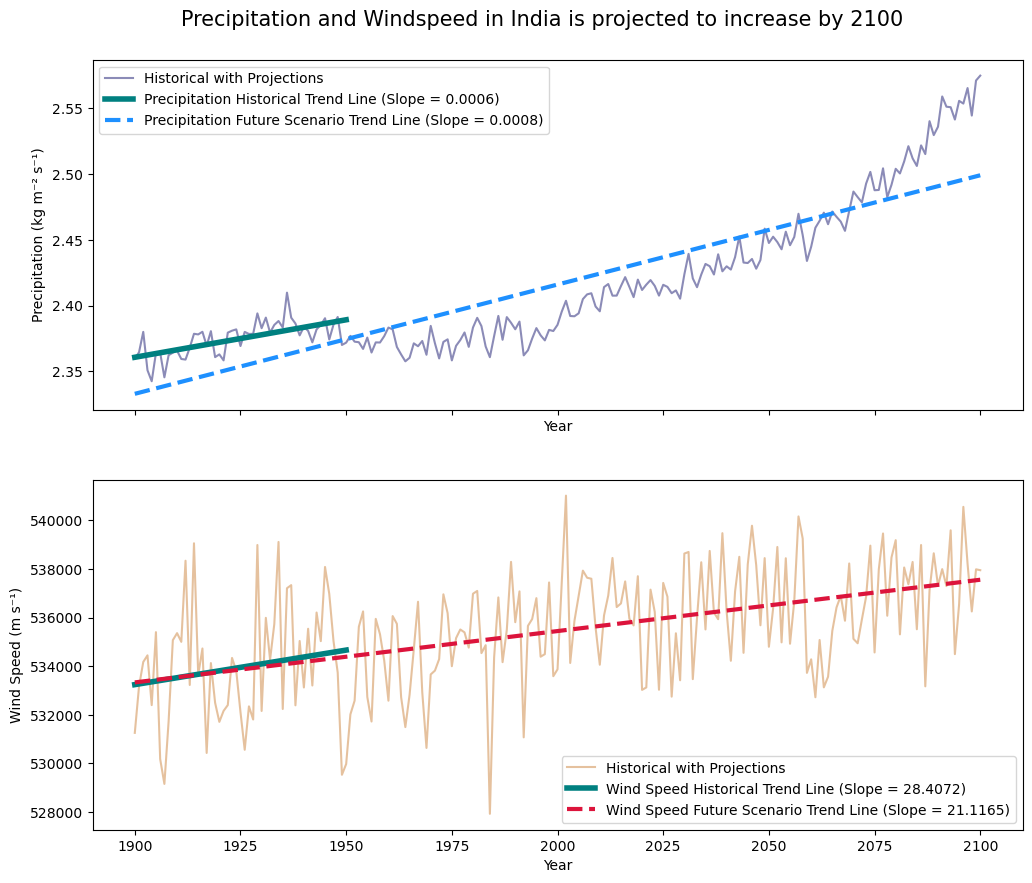

In [10]:
visualize_model(
    [sim_trend_precip, sim_trend_wind], # predicting trendlines
    [hist_trend_precip, hist_trend_wind], # historical trendline
    [sim_mean_precip, sim_mean_wind], # predicting yearly averages for soil moisture
    [hist_mean_precip, hist_mean_wind], # historical yearly average
    [sim_slope_precip, sim_slope_wind], # predictive coefs from linear regression (slope and y int, but we only use slope)
    [hist_slope_precip, hist_slope_wind], # historical lin reg coeffs
    'Precipitation and Windspeed in India is projected to increase by 2100' # title of graph
)

## Correlation Patterns

In [11]:
# Convert to a series
precip_series = sim_mean_precip.to_series()
wind_series = sim_mean_wind.to_series()

# Align both series by the index, year
combined = pd.concat([precip_series, wind_series], axis = 1).dropna()
combined.columns = ['precip', 'wind']

In [12]:
# Perform correlation analysis
correlation = combined.corr().iloc[0,1]
print(f"Correlation: {correlation:.4f}")

Correlation: 0.5072


## Metrics

In [13]:
# Compute basic statistics
avg_precip = precip_series.mean()
avg_wind = wind_series.mean()
max_precip = precip_series.max()
max_wind = wind_series.max()
min_precip = precip_series.min()
min_wind = wind_series.min()
std_precip = precip_series.std()
std_wind = wind_series.std()

# Print statistics
print(f"Average Precipitation: {avg_precip:.2f}")
print(f"Average Wind Speed: {avg_wind:.2f}")
print(f"Max Precipitation: {max_precip:.2f}")
print(f"Max Wind Speed: {max_wind:.2f}")
print(f"Min Precipitation: {min_precip:.2f}")
print(f"Min Wind Speed: {min_wind:.2f}")
print(f"Standard Deviation Precipitation: {std_precip:.2f}")
print(f"Standard Deviation Wind Speed: {std_precip:.2f}")

Average Precipitation: 2.42
Average Wind Speed: 535444.21
Max Precipitation: 2.57
Max Wind Speed: 541015.31
Min Precipitation: 2.34
Min Wind Speed: 527926.83
Standard Deviation Precipitation: 0.05
Standard Deviation Wind Speed: 0.05


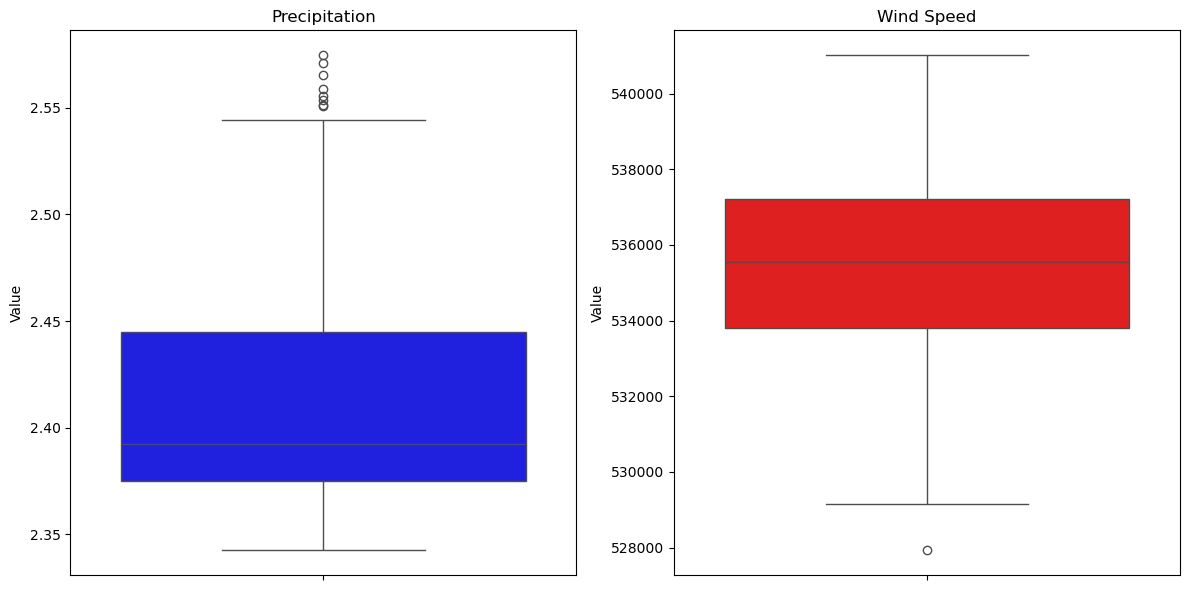

In [14]:
# Look at the distribution of the two variables' data
fig, axes = plt.subplots(1, 2, figsize =( 12, 6))

# Boxplot for Precipitation
sns.boxplot(y = precip_series, ax = axes[0], color = 'blue')
axes[0].set_title('Precipitation')
axes[0].set_ylabel('Value')
axes[0].set_xlabel('')

# Boxplot for Wind Speed
sns.boxplot(y = wind_series, ax = axes[1], color = 'red')
axes[1].set_title('Wind Speed')
axes[1].set_ylabel('Value')
axes[1].set_xlabel('')

# Display plots
plt.tight_layout()
plt.show()

## Correlation Analysis

#### Run query for all ensemble members

In [15]:
# Convert the catalog to a Pandas datazrame
cat_df2 = catalog.df

# Search through catalog, find all historical simulations
res = catalog.search(
    activity_id=activity_ids, 
    variable_id = variable, 
    table_id = spatial_temporal, 
    source_id = models, 
    experiment_id = "historical"
)

# Convert to a data frame
res_df2 = res.df
res_df2

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,sfcWind,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
1,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
2,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r5i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
3,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r5i1p1f1,Amon,sfcWind,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
4,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r4i1p1f1,Amon,sfcWind,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
5,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r4i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
6,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r3i1p1f1,Amon,sfcWind,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
7,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r3i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
8,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r2i1p1f1,Amon,sfcWind,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
9,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r2i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710


In [16]:
# split query between vars
precip_rows = res_df2[res_df2["variable_id"] == "pr"]
wind_rows = res_df2[res_df2["variable_id"] == "sfcWind"]

# get all the different ensembles in each var
precip_ensembles = precip_rows.member_id.unique()
wind_ensembles = wind_rows.member_id.unique()

# and just select the common ones
common_ens = list(set(precip_ensembles) & set(wind_ensembles))

print(common_ens)

['r1i1p1f1', 'r8i1p1f1', 'r10i1p1f1', 'r3i1p1f1', 'r2i1p1f1', 'r7i1p1f1', 'r9i1p1f1', 'r4i1p1f1', 'r5i1p1f1', 'r6i1p1f1']


In [17]:
def coorelation_zarr_rows(df1, df2, common_ensembles, bbox, groupby_var = 'time'):

    list1 = []
    list2 = []
    
    for i in range(len(common_ensembles)):
        print(common_ensembles[i])

        # Extract member of interest
        extract1 = df1[(df1["member_id"] == common_ensembles[i])]
        extract2 = df2[(df2["member_id"] == common_ensembles[i])]

        # Store data as xarray
        xr1 = xr.open_zarr(extract1['zstore'].iloc[0], storage_options={'anon': True}).load()
        xr2 = xr.open_zarr(extract2['zstore'].iloc[0], storage_options={'anon': True}).load()

        # Reassign time for all entries aside from the first one
        if i == 0:
            common_time = xr2.time
        else:
            xr2['time'] = common_time    

        # Add to list
        list1.append(xr1)
        list2.append(xr2)
        
        
        
        
        
    # Concatenate the list into a single xarray object
    xr_concat_1 = xr.concat(list1, dim="member")
    xr_concat_2 = xr.concat(list2, dim="member")

    # Store the actual member information as values of the new dimension
    xr_concat_1 = xr_concat_1.assign_coords(member=("member", common_ensembles))
    xr_concat_2 = xr_concat_2.assign_coords(member=("member", common_ensembles))

    # Reformat time dimension for concatenated array
    xr_concat_1['time'] = xr_concat_1.time.astype('datetime64[ns]')
    xr_concat_2['time'] = xr_concat_2.time.astype('datetime64[ns]')
    
    
    
    # mask
    
    # Specify rough lat/lon bounds for NINO3.4
    lat_min, lat_max, lon_min, lon_max = [*bbox]

    # Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
    mask_lat1 = (xr_concat_1.lat >= lat_min) & (xr_concat_1.lat <= lat_max)
    mask_lon1 = (xr_concat_1.lon >= lon_min) & (xr_concat_1.lon <= lon_max)

    mask_lat2 = (xr_concat_2.lat >= lat_min) & (xr_concat_2.lat <= lat_max)
    mask_lon2 = (xr_concat_2.lon >= lon_min) & (xr_concat_2.lon <= lon_max)
    
    # Find points where the mask value is True, drop all other points
    xr_concat_1 = xr_concat_1.where(mask_lat1 & mask_lon1, drop=True)
    xr_concat_2 = xr_concat_2.where(mask_lat2 & mask_lon2, drop=True)

    
    # Average over the lat and lon dimensions
    if groupby_var == "time":
        xr_concat_1 = xr_concat_1.mean(dim="lat").mean(dim="lon")
        xr_concat_2 = xr_concat_2.mean(dim="lat").mean(dim="lon")
    
        # groupby
        xr_concat_1 = xr_concat_1.groupby("time.year").mean("time")
        xr_concat_2 = xr_concat_2.groupby("time.year").mean("time")
        
    elif groupby_var == "space":
        xr_concat_1 = xr_concat_1.mean(dim="time")
        xr_concat_2 = xr_concat_2.mean(dim="time")
        
        
    return xr_concat_1, xr_concat_2

In [18]:
# declare bbox
full_bbox = [lat_min, lat_max, lon_min, lon_max]

precip_ens_df, wind_ens_df = coorelation_zarr_rows(precip_rows, wind_rows, common_ens, full_bbox)

r1i1p1f1
r8i1p1f1
r10i1p1f1
r3i1p1f1
r2i1p1f1
r7i1p1f1
r9i1p1f1
r4i1p1f1
r5i1p1f1
r6i1p1f1


In [19]:
precip_ens_df2, wind_ens_df2 = coorelation_zarr_rows(precip_rows, wind_rows, common_ens, full_bbox, groupby_var = 'space')

r1i1p1f1
r8i1p1f1
r10i1p1f1
r3i1p1f1
r2i1p1f1
r7i1p1f1
r9i1p1f1
r4i1p1f1
r5i1p1f1
r6i1p1f1


In [20]:
def corr_ts(x, y):
    # Get rid of any Nan/Inf values
    mask = np.isfinite(x) & np.isfinite(y)
    
    # Make sure there is still data
    if mask.sum() < 2:
        return np.nan, np.nan
    
    # Output data: R, p-value for x vs y
    r, p = stats.pearsonr(x[mask], y[mask])
    
    return float(r), float(p)

# 2) regression
# Input data: two time series called x and y
def reg_ts(x, y):
    # Get rid of any Nan/Inf values
    mask = np.isfinite(x) & np.isfinite(y)

    # Make sure there is still data
    if mask.sum() < 2:
        return np.nan, np.nan
    
    # Perform regression on good data, return slope and p-value
    regval = stats.linregress(x[mask], y[mask])
    return regval.slope, regval.pvalue

In [21]:

t = 0

# make container for bucket df
df_fill = {
    "lat": pd.Series(dtype = float),
    "lon": pd.Series(dtype = float),
    "windspeed": pd.Series(dtype = float),
    "precipitation": pd.Series(dtype = float)
}

# bucket df that will be used for plotting
plotted_df2 = pd.DataFrame(df_fill)

# for all combinations of lat and lon
for lat in wind_ens_df2.lat:
    for lon in wind_ens_df2.lon:
    
        wind_list = []
        precip_list = []
        
        # print after every 10 lat lons
        if t == 10:
            print(f"values for {lat.values}, {lon.values}")
            t = 0
        
        t+=1

        # make a list of every ensemble for a given lat lon per variable
        for member in wind_ens_df.member:
            wind_list.append(wind_ens_df2.sel(lat = lat, lon = lon, member = member))
            precip_list.append(precip_ens_df2.sel(lat = lat, lon = lon, member = member))

        # concat the lists into a df
        wind_list = xr.concat(wind_list, dim = 'member')
        precip_list = xr.concat(precip_list, dim = 'member')

        # aggregate and drop extraneous coords
        wind_mean = wind_list.sfcWind.mean().drop("height")
        precip_mean = precip_list.pr.mean().drop("height")


        # put them into the df bucket
        append_list =[lat.values, lon.values, wind_mean.values, precip_mean.values]
        plotted_df2.loc[len(plotted_df2)] = append_list


        # make it geospatial
        plotted_gdf = gpd.GeoDataFrame(
            plotted_df2, geometry=gpd.points_from_xy(plotted_df2.lon, plotted_df2.lat), crs="EPSG:4326"
        )



plotted_gdf


values for 7.0129632380243265, 77.8125
values for 7.0129632380243265, 87.1875
values for 7.0129632380243265, 96.5625
values for 7.948024964485844, 76.875
values for 7.948024964485844, 86.25
values for 7.948024964485844, 95.625
values for 8.883086676291583, 75.9375
values for 8.883086676291583, 85.3125
values for 8.883086676291583, 94.6875
values for 9.818148371611526, 75.0
values for 9.818148371611526, 84.375
values for 9.818148371611526, 93.75
values for 10.75321004857906, 74.0625
values for 10.75321004857906, 83.4375
values for 10.75321004857906, 92.8125
values for 11.688271705286827, 73.125
values for 11.688271705286827, 82.5
values for 11.688271705286827, 91.875
values for 12.623333339781855, 72.1875
values for 12.623333339781855, 81.5625
values for 12.623333339781855, 90.9375
values for 13.558394950060816, 71.25
values for 13.558394950060816, 80.625
values for 13.558394950060816, 90.0
values for 14.493456534064881, 70.3125
values for 14.493456534064881, 79.6875
values for 14.49345

,lat,lon,windspeed,precipitation,geometry
0,7.0129632380243265,68.4375,5.181918,5.265598e-05,POINT (68.43750 7.01296)
1,7.0129632380243265,69.375,5.0358934,5.1844552e-05,POINT (69.37500 7.01296)
2,7.0129632380243265,70.3125,4.921586,5.2096217e-05,POINT (70.31250 7.01296)
3,7.0129632380243265,71.25,4.8624406,5.8396603e-05,POINT (71.25000 7.01296)
4,7.0129632380243265,72.1875,4.822913,6.383953e-05,POINT (72.18750 7.01296)
...,...,...,...,...,...
1018,36.93491964067397,92.8125,4.234504,6.913439e-06,POINT (92.81250 36.93492)
1019,36.93491964067397,93.75,3.740086,3.592521e-06,POINT (93.75000 36.93492)
1020,36.93491964067397,94.6875,3.4615371,2.1025232e-06,POINT (94.68750 36.93492)
1021,36.93491964067397,95.625,3.4715316,2.6956557e-06,POINT (95.62500 36.93492)


Text(0.5, 1.0, 'precipitation')

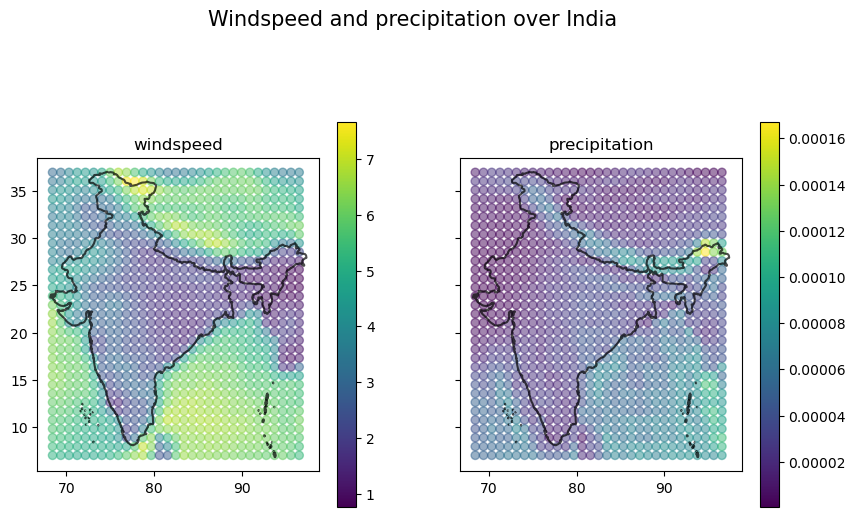

In [34]:
# make the plotted vars the right dtype
plotted_gdf['windspeed'] = plotted_gdf['windspeed'].astype(float)
plotted_gdf['precipitation'] = plotted_gdf['precipitation'].astype(float)

# titles an init struture
title = "Windspeed and precipitation over India"
fig, ax = plt.subplots(figsize = (10,10), ncols=2, sharey = True)
fig.suptitle(title, y = 0.80, fontsize = 15)

# plot india boundary twice for both vars
for i in range(2):
    india_boundary.boundary.plot(ax=ax[i], alpha =0.7, color = "black")
    
# then plot the gdf overtop of it
plotted_gdf.plot(ax=ax[0], alpha= 0.5, column = "windspeed", legend = True, legend_kwds = {"shrink": 0.5})
plotted_gdf.plot(ax=ax[1], alpha= 0.5, column = "precipitation", legend = True, legend_kwds = {"shrink": 0.5})

# plt.colorbar()
# ax[1].colorbar()

# add titles to both plots
ax[0].set_title("windspeed")
ax[1].set_title("precipitation")

In [25]:
print(f"________Coefficients between windspeed and rainfall_________")
print(f"Correlation: {corr_ts(plotted_gdf['precipitation'], plotted_gdf['windspeed'])[0]}")
print(f"Regression: {reg_ts(plotted_gdf['precipitation'], plotted_gdf['windspeed'])[0]}")

________Coefficients between windspeed and rainfall_________
Correlation: 0.21960152102045385
Regression: 15173.79028296059


### 

### Conclusion

### Citations

Government of India. (2025, January). Agriculture and Food Management: Sector of the 
Future https://www.indiabudget.gov.in/economicsurvey/doc/eschapter/echap09.pdf 

Sahastrabuddhe, R., Ghausi, S. A., Joseph, J., & Ghosh, S. (2023). Indian summer monsoon rainfall in a changing climate: A Review. Journal of Water and Climate Change, 14(4), 1061–1088. https://doi.org/10.2166/wcc.2023.127 

Douglas, I. (2009). Climate change, flooding and Food Security in South Asia. Food Security, 1(2), 127–136. https://doi.org/10.1007/s12571-009-0015-1

Chen, Y. J., Hwang, Y. T., & Lu, J. (2024). Robust increase in South Asian monsoon rainfall under warming driven by extratropical clouds and Ocean. Npj Climate and Atmospheric Science, 7(1). https://doi.org/10.1038/s41612-024-00843-7

Li, X., Ting, M., Li, C., & Henderson, N. (2015). Mechanisms of asian summer monsoon changes in response to anthropogenic forcing in CMIP5 models. Journal of Climate, 28(10), 4107–4125. https://doi.org/10.1175/jcli-d-14-00559.1 